In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install split-folders

In [2]:
import splitfolders
splitfolders.ratio('/kaggle/input/indian-food-recipes/FoodyMood', output= 'Data', seed= 1337, ratio=(.8,0.1,0.1))

Copying files: 31962 files [04:58, 107.22 files/s]


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 200
batch_size = 32
img_width, img_height = 224, 224
train_dir  = '/kaggle/working/Data/train'
val_dir = '/kaggle/working/Data/val'


train_datagen = ImageDataGenerator(
    rescale = 1. /255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True)

val_datagen = ImageDataGenerator(
    rescale = 1. /255)



train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width, img_height),
    class_mode = 'categorical')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 25293 images belonging to 200 classes.
Found 3092 images belonging to 200 classes.


In [4]:
class_map = train_data.class_indices
class_map

{'Adhirasam': 0,
 'Aloo gobi': 1,
 'Aloo matar': 2,
 'Aloo methi': 3,
 'Aloo shimla mirch': 4,
 'Aloo tikki': 5,
 'Alu Pitika': 6,
 'Amti': 7,
 'Anarsa': 8,
 'Ariselu': 9,
 'Avial': 10,
 'Baingan Fry': 11,
 'Bajri no rotlo': 12,
 'Balu shahi': 13,
 'Bandar laddu': 14,
 'Basundi': 15,
 'Bebinca': 16,
 'Bhakri': 17,
 'Bhatura': 18,
 'Bhindi masala': 19,
 'Biryani': 20,
 'Bisi bele bath': 21,
 'Black rice': 22,
 'Bombil fry': 23,
 'Brown Rice': 24,
 'Butter chicken': 25,
 'Chak Hao Kheer': 26,
 'Chakali': 27,
 'Cham cham': 28,
 'Chana masala': 29,
 'Chapati': 30,
 'Chevdo': 31,
 'Chhena jalebi': 32,
 'Chhena kheeri': 33,
 'Chhena poda': 34,
 'Chicken Tikka': 35,
 'Chicken Tikka masala': 36,
 'Chicken Varuval': 37,
 'Chicken razala': 38,
 'Chikki': 39,
 'Chingri Bhape': 40,
 'Chingri malai curry': 41,
 'Chole bhature': 42,
 'Chorafali': 43,
 'Churma Ladoo': 44,
 'Daal Dhokli': 45,
 'Daal baati churma': 46,
 'Daal puri': 47,
 'Dahi vada': 48,
 'Dal Makhani': 49,
 'Dal tadka': 50,
 'Dalithoy

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

In [6]:
train_samples = 25293
val_samples = 3092

checkpointer = ModelCheckpoint(filepath='v1_inceptionV3', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_v1_inceptionV3.log')

# create the base pre-trained model
conv_base = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(200,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=conv_base.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
conv_base.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ['accuracy'])



87910968/87910968 [==============================] - 0s 0us/step


In [7]:
# train the model on the new data for a few epochs
history = model.fit(
        train_data,
        steps_per_epoch = train_samples // batch_size,
        epochs = 5,
        validation_data = val_data,
        validation_steps = val_samples // batch_size,
        verbose = 1, 
        callbacks = [csv_logger, checkpointer])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/5
 59/790 [=>............................] - ETA: 8:35 - loss: 6.7113 - accuracy: 0.0159

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 4.7337 - accuracy: 0.1463
Epoch 1: val_loss improved from inf to 4.45756, saving model to v1_inceptionV3
790/790 [==============================] - 618s 768ms/step - loss: 4.7337 - accuracy: 0.1463 - val_loss: 4.4576 - val_accuracy: 0.2516
Epoch 2/5
 25/790 [..............................] - ETA: 8:26 - loss: 4.5230 - accuracy: 0.2488

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 5.0947 - accuracy: 0.2610
Epoch 2: val_loss did not improve from 4.45756
790/790 [==============================] - 570s 722ms/step - loss: 5.0947 - accuracy: 0.2610 - val_loss: 5.4299 - val_accuracy: 0.3128
Epoch 3/5
790/790 [==============================] - ETA: 0s - loss: 6.0834 - accuracy: 0.2845
Epoch 3: val_loss did not improve from 4.45756
790/790 [==============================] - 540s 683ms/step - loss: 6.0834 - accuracy: 0.2845 - val_loss: 6.4159 - val_accuracy: 0.3343
Epoch 4/5
790/790 [==============================] - ETA: 0s - loss: 6.9809 - accuracy: 0.3018
Epoch 4: val_loss did not improve from 4.45756
790/790 [==============================] - 529s 668ms/step - loss: 6.9809 - accuracy: 0.3018 - val_loss: 7.2178 - val_accuracy: 0.3454
Epoch 5/5
790/790 [==============================] - ETA: 0s - loss: 7.8169 - accuracy: 0.3066
Epoch 5: val_loss did not improve from 4.45756
790/790 [============================

In [9]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers


In [10]:
history = model.fit(
        train_data,
        steps_per_epoch = train_samples // batch_size,
        epochs = 20,
        validation_data = val_data,
        validation_steps = val_samples // batch_size,
        verbose = 1,
        callbacks = [csv_logger, checkpointer])

Epoch 1/20
790/790 [==============================] - ETA: 0s - loss: 5.7393 - accuracy: 0.2837
Epoch 1: val_loss improved from inf to 3.83013, saving model to v1_inceptionV3
790/790 [==============================] - 550s 688ms/step - loss: 5.7393 - accuracy: 0.2837 - val_loss: 3.8301 - val_accuracy: 0.3841
Epoch 2/20
  2/790 [..............................] - ETA: 16:25 - loss: 3.8666 - accuracy: 0.3750

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 3.2389 - accuracy: 0.3991
Epoch 2: val_loss improved from 3.83013 to 2.85844, saving model to v1_inceptionV3
790/790 [==============================] - 538s 681ms/step - loss: 3.2389 - accuracy: 0.3991 - val_loss: 2.8584 - val_accuracy: 0.4303
Epoch 3/20
 28/790 [>.............................] - ETA: 8:14 - loss: 2.6654 - accuracy: 0.4621

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 2.5487 - accuracy: 0.4676
Epoch 3: val_loss improved from 2.85844 to 2.60043, saving model to v1_inceptionV3
790/790 [==============================] - 552s 699ms/step - loss: 2.5487 - accuracy: 0.4676 - val_loss: 2.6004 - val_accuracy: 0.4557
Epoch 4/20
 27/790 [>.............................] - ETA: 7:39 - loss: 2.0763 - accuracy: 0.5833

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 2.2530 - accuracy: 0.5144
Epoch 4: val_loss improved from 2.60043 to 2.45117, saving model to v1_inceptionV3
790/790 [==============================] - 547s 693ms/step - loss: 2.2530 - accuracy: 0.5144 - val_loss: 2.4512 - val_accuracy: 0.4925
Epoch 5/20
 11/790 [..............................] - ETA: 8:18 - loss: 2.0409 - accuracy: 0.5966

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 2.0625 - accuracy: 0.5513
Epoch 5: val_loss did not improve from 2.45117
790/790 [==============================] - 523s 662ms/step - loss: 2.0625 - accuracy: 0.5513 - val_loss: 2.5413 - val_accuracy: 0.4827
Epoch 6/20
790/790 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.5939
Epoch 6: val_loss did not improve from 2.45117
790/790 [==============================] - 516s 653ms/step - loss: 1.8839 - accuracy: 0.5939 - val_loss: 2.4980 - val_accuracy: 0.5023
Epoch 7/20
790/790 [==============================] - ETA: 0s - loss: 1.7280 - accuracy: 0.6328
Epoch 7: val_loss improved from 2.45117 to 2.42010, saving model to v1_inceptionV3
790/790 [==============================] - 544s 689ms/step - loss: 1.7280 - accuracy: 0.6328 - val_loss: 2.4201 - val_accuracy: 0.5335
Epoch 8/20
 10/790 [..............................] - ETA: 7:11 - loss: 1.3942 - accuracy: 0.7094

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 1.6080 - accuracy: 0.6600
Epoch 8: val_loss did not improve from 2.42010
790/790 [==============================] - 523s 662ms/step - loss: 1.6080 - accuracy: 0.6600 - val_loss: 2.4494 - val_accuracy: 0.5459
Epoch 9/20
790/790 [==============================] - ETA: 0s - loss: 1.4889 - accuracy: 0.6871
Epoch 9: val_loss did not improve from 2.42010
790/790 [==============================] - 528s 668ms/step - loss: 1.4889 - accuracy: 0.6871 - val_loss: 2.5642 - val_accuracy: 0.5326
Epoch 10/20
790/790 [==============================] - ETA: 0s - loss: 1.3842 - accuracy: 0.7123
Epoch 10: val_loss improved from 2.42010 to 2.34995, saving model to v1_inceptionV3
790/790 [==============================] - 541s 685ms/step - loss: 1.3842 - accuracy: 0.7123 - val_loss: 2.3500 - val_accuracy: 0.5521
Epoch 11/20
 17/790 [..............................] - ETA: 8:01 - loss: 1.1396 - accuracy: 0.7923

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 1.2681 - accuracy: 0.7470
Epoch 11: val_loss did not improve from 2.34995
790/790 [==============================] - 517s 654ms/step - loss: 1.2681 - accuracy: 0.7470 - val_loss: 2.4352 - val_accuracy: 0.5592
Epoch 12/20
790/790 [==============================] - ETA: 0s - loss: 1.1832 - accuracy: 0.7685
Epoch 12: val_loss did not improve from 2.34995
790/790 [==============================] - 513s 649ms/step - loss: 1.1832 - accuracy: 0.7685 - val_loss: 2.4394 - val_accuracy: 0.5602
Epoch 13/20
790/790 [==============================] - ETA: 0s - loss: 1.1096 - accuracy: 0.7818
Epoch 13: val_loss improved from 2.34995 to 2.30944, saving model to v1_inceptionV3
790/790 [==============================] - 534s 676ms/step - loss: 1.1096 - accuracy: 0.7818 - val_loss: 2.3094 - val_accuracy: 0.5859
Epoch 14/20
 11/790 [..............................] - ETA: 7:48 - loss: 1.0132 - accuracy: 0.8097

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


790/790 [==============================] - ETA: 0s - loss: 1.0089 - accuracy: 0.8073
Epoch 14: val_loss did not improve from 2.30944
790/790 [==============================] - 528s 668ms/step - loss: 1.0089 - accuracy: 0.8073 - val_loss: 2.4640 - val_accuracy: 0.5667
Epoch 15/20
790/790 [==============================] - ETA: 0s - loss: 0.9704 - accuracy: 0.8203
Epoch 15: val_loss did not improve from 2.30944
790/790 [==============================] - 508s 643ms/step - loss: 0.9704 - accuracy: 0.8203 - val_loss: 2.3167 - val_accuracy: 0.5957
Epoch 16/20
790/790 [==============================] - ETA: 0s - loss: 0.9052 - accuracy: 0.8346
Epoch 16: val_loss did not improve from 2.30944
790/790 [==============================] - 527s 667ms/step - loss: 0.9052 - accuracy: 0.8346 - val_loss: 2.4525 - val_accuracy: 0.5843
Epoch 17/20
790/790 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.8491
Epoch 17: val_loss did not improve from 2.30944
790/790 [==================

In [11]:
model.save('model_v3_inceptionV3_200.h5')

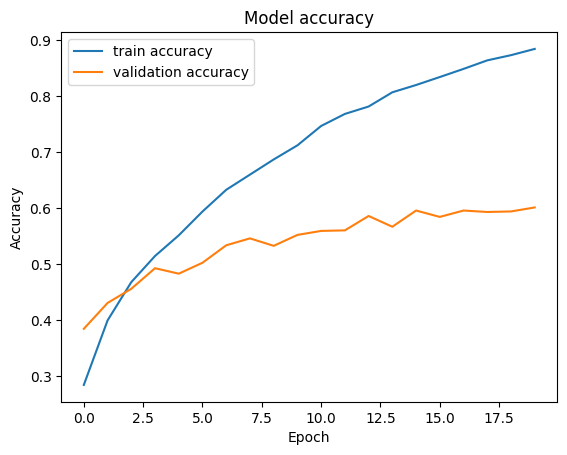

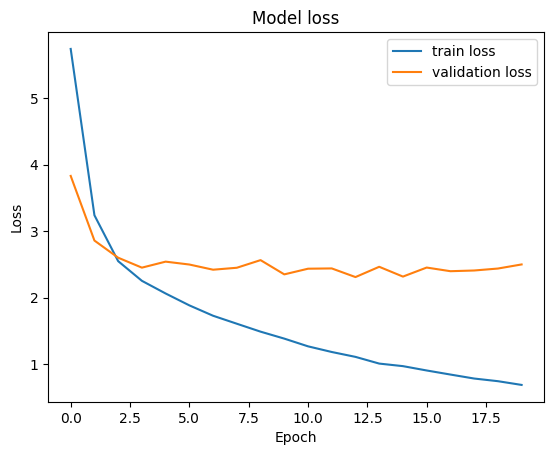

In [12]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3_200')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3_200')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [ ]:
path_to_model='./model_v3_inceptionV3_200.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")


In [13]:
test_data_dir = '/kaggle/working/Data/test'

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3332 images belonging to 200 classes.


In [14]:
scores = model.evaluate_generator(test_generator)

print("Test Accuracy: {:.3f}".format(scores[1]))

/tmp/ipykernel_28/430069557.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


Test Accuracy: 0.607


In [16]:
category = {0: ['adhirasam', 'Adhirasam'], 1: ['aloo_gobi', 'Aloo gobi'], 2: ['aloo_matar', 'Aloo matar'], 3: ['aloo_methi', 'Aloo methi'], 4: ['aloo_shimla_mirch', 'Aloo shimla mirch'], 5: ['aloo_tikki', 'Aloo tikki'], 6: ['alu_pitika', 'Alu Pitika'], 7: ['amti', 'Amti'], 8: ['anarsa', 'Anarsa'], 9: ['ariselu', 'Ariselu'], 10: ['avial', 'Avial'], 11: ['baingan_fry', 'Baingan Fry'], 12: ['bajri_no_rotlo', 'Bajri no rotlo'], 13: ['balu_shahi', 'Balu shahi'], 14: ['bandar_laddu', 'Bandar laddu'], 15: ['basundi', 'Basundi'], 16: ['bebinca', 'Bebinca'], 17: ['bhakri', 'Bhakri'], 18: ['bhatura', 'Bhatura'], 19: ['bhindi_masala', 'Bhindi masala'], 20: ['biryani', 'Biryani'], 21: ['bisi_bele_bath', 'Bisi bele bath'], 22: ['black_rice', 'Black rice'], 23: ['bombil_fry', 'Bombil fry'], 24: ['brown_rice', 'Brown Rice'], 25: ['butter_chicken', 'Butter chicken'], 26: ['chak_hao_kheer', 'Chak Hao Kheer'], 27: ['chakali', 'Chakali'], 28: ['cham_cham', 'Cham cham'], 29: ['chana_masala', 'Chana masala'], 30: ['chapati', 'Chapati'], 31: ['chevdo', 'Chevdo'], 32: ['chhena_jalebi', 'Chhena jalebi'], 33: ['chhena_kheeri', 'Chhena kheeri'], 34: ['chhena_poda', 'Chhena poda'], 35: ['chicken_tikka', 'Chicken Tikka'], 36: ['chicken_tikka_masala', 'Chicken Tikka masala'], 37: ['chicken_varuval', 'Chicken Varuval'], 38: ['chicken_razala', 'Chicken razala'], 39: ['chikki', 'Chikki'], 40: ['chingri_bhape', 'Chingri Bhape'], 41: ['chingri_malai_curry', 'Chingri malai curry'], 42: ['chole_bhature', 'Chole bhature'], 43: ['chorafali', 'Chorafali'], 44: ['churma_ladoo', 'Churma Ladoo'], 45: ['daal_dhokli', 'Daal Dhokli'], 46: ['daal_baati_churma', 'Daal baati churma'], 47: ['daal_puri', 'Daal puri'], 48: ['dahi_vada', 'Dahi vada'], 49: ['dal_makhani', 'Dal Makhani'], 50: ['dal_tadka', 'Dal tadka'], 51: ['dalithoy', 'Dalithoy'], 52: ['dharwad_pedha', 'Dharwad pedha'], 53: ['dhokla', 'Dhokla'], 54: ['doodhpak', 'Doodhpak'], 55: ['dosa', 'Dosa'], 56: ['double_ka_meetha', 'Double ka meetha'], 57: ['dudhi_halwa', 'Dudhi halwa'], 58: ['dum_aloo', 'Dum aloo'], 59: ['farsi_puri', 'Farsi Puri'], 60: ['gajar_ka_halwa', 'Gajar ka halwa'], 61: ['gatta_curry', 'Gatta curry'], 62: ['ghevar', 'Ghevar'], 63: ['gud_papdi', 'Gud papdi'], 64: ['gulab_jamun', 'Gulab jamun'], 65: ['halvasan', 'Halvasan'], 66: ['idiappam', 'Idiappam'], 67: ['idli', 'Idli'], 68: ['imarti', 'Imarti'], 69: ['jalebi', 'Jalebi'], 70: ['jeera_aloo', 'Jeera Aloo'], 71: ['kaara_kozhambu', 'Kaara kozhambu'], 72: ['kabiraji', 'Kabiraji'], 73: ['kachori', 'Kachori'], 74: ['kadai_paneer', 'Kadai paneer'], 75: ['kadhi_pakoda', 'Kadhi pakoda'], 76: ['kajjikaya', 'Kajjikaya'], 77: ['kaju_katli', 'Kaju katli'], 78: ['kakinada_khaja', 'Kakinada khaja'], 79: ['kalakand', 'Kalakand'], 80: ['karela_bharta', 'Karela bharta'], 81: ['keerai_kootu', 'Keerai kootu'], 82: ['keerai_masiyal', 'Keerai masiyal'], 83: ['keerai_poriyal', 'Keerai poriyal'], 84: ['keerai_sadam', 'Keerai sadam'], 85: ['khakhra', 'Khakhra'], 86: ['khaman', 'Khaman'], 87: ['khandvi', 'Khandvi'], 88: ['kheer', 'Kheer'], 89: ['khichdi', 'Khichdi'], 90: ['khichu', 'Khichu'], 91: ['khorisa', 'Khorisa'], 92: ['kofta', 'Kofta'], 93: ['koldil_chicken', 'Koldil Chicken'], 94: ['kombdi_vade', 'Kombdi vade'], 95: ['kootu', 'Kootu'], 96: ['koshambri', 'Koshambri'], 97: ['koshimbir', 'Koshimbir'], 98: ['kothamali_sadam', 'Kothamali sadam'], 99: ['kuzhambu', 'Kuzhambu'], 100: ['kuzhi_paniyaram', 'Kuzhi paniyaram'], 101: ['laddu', 'Laddu'], 102: ['lassi', 'Lassi'], 103: ['lauki_ke_kofte', 'Lauki ke kofte'], 104: ['lauki_ki_subji', 'Lauki ki subji'], 105: ['lilva_kachori', 'Lilva Kachori'], 106: ['litti_chokha', 'Litti chokha'], 107: ['luchi', 'Luchi'], 108: ['lyangcha', 'Lyangcha'], 109: ['maach_jhol', 'Maach Jhol'], 110: ['mag_dhokli', 'Mag Dhokli'], 111: ['mahim_halwa', 'Mahim halwa'], 112: ['makki_di_roti_sarson_da_saag', 'Makki di roti sarson da saag'], 113: ['malapua', 'Malapua'], 114: ['masala_dosa', 'Masala Dosa'], 115: ['masor_tenga', 'Masor tenga'], 116: ['mawa_bati', 'Mawa Bati'], 117: ['methi_na_gota', 'Methi na Gota'], 118: ['mihidana', 'Mihidana'], 119: ['misi_roti', 'Misi roti'], 120: ['misti_doi', 'Misti doi'], 121: ['modak', 'Modak'], 122: ['mohanthal', 'Mohanthal'], 123: ['mushroom_do_pyaza', 'Mushroom do pyaza'], 124: ['mushroom_matar', 'Mushroom matar'], 125: ['muthiya', 'Muthiya'], 126: ['mysore_pak', 'Mysore pak'], 127: ['naan', 'Naan'], 128: ['namakpara', 'Namakpara'], 129: ['nankhatai', 'Nankhatai'], 130: ['navrattan_korma', 'Navrattan korma'], 131: ['palak_paneer', 'Palak paneer'], 132: ['paneer_butter_masala', 'Paneer butter masala'], 133: ['paneer_tikka_masala', 'Paneer tikka masala'], 134: ['pani_puri', 'Pani puri'], 135: ['panjeeri', 'Panjeeri'], 136: ['papad', 'Papad'], 137: ['paruppu_sadam', 'Paruppu sadam'], 138: ['pav_bhaji', 'Pav Bhaji'], 139: ['petha', 'Petha'], 140: ['phirni', 'Phirni'], 141: ['pindi_chana', 'Pindi chana'], 142: ['poha', 'Poha'], 143: ['pongal', 'Pongal'], 144: ['poornalu', 'Poornalu'], 145: ['pootharekulu', 'Pootharekulu'], 146: ['poriyal', 'Poriyal'], 147: ['pork_bharta', 'Pork Bharta'], 148: ['prawn_malai_curry', 'Prawn malai curry'], 149: ['puli_sadam', 'Puli sadam'], 150: ['puri_bhaji', 'Puri Bhaji'], 151: ['puttu', 'Puttu'], 152: ['qubani_ka_meetha', 'Qubani ka meetha'], 153: ['rabri', 'Rabri'], 154: ['rajma_chaval', 'Rajma chaval'], 155: ['ras_malai', 'Ras malai'], 156: ['rasabali', 'Rasabali'], 157: ['rasam', 'Rasam'], 158: ['rasgulla', 'Rasgulla'], 159: ['red_rice', 'Red Rice'], 160: ['rongi', 'Rongi'], 161: ['sabudana_khichadi', 'Sabudana Khichadi'], 162: ['sambar', 'Sambar'], 163: ['samosa', 'Samosa'], 164: ['sandesh', 'Sandesh'], 165: ['sandige', 'Sandige'], 166: ['sattu_ki_roti', 'Sattu ki roti'], 167: ['sev_khamani', 'Sev khamani'], 168: ['sev_tameta', 'Sev tameta'], 169: ['sevai', 'Sevai'], 170: ['shahi_paneer', 'Shahi paneer'], 171: ['shahi_tukra', 'Shahi tukra'], 172: ['shankarpali', 'Shankarpali'], 173: ['sheer_khurma', 'Sheer khurma'], 174: ['sheera', 'Sheera'], 175: ['shrikhand', 'Shrikhand'], 176: ['shufta', 'Shufta'], 177: ['shukto', 'Shukto'], 178: ['singori', 'Singori'], 179: ['sohan_papdi', 'Sohan papdi'], 180: ['sukhdi', 'Sukhdi'], 181: ['surnoli', 'Surnoli'], 182: ['sutar_feni', 'Sutar feni'], 183: ['tandoori_chicken', 'Tandoori Chicken'], 184: ['tandoori_fish_tikka', 'Tandoori Fish Tikka'], 185: ['thalipeeth', 'Thalipeeth'], 186: ['thayir_sadam', 'Thayir sadam'], 187: ['theeyal', 'Theeyal'], 188: ['thepla', 'Thepla'], 189: ['til_pitha', 'Til Pitha'], 190: ['turiya_patra_vatana_sabji', 'Turiya Patra Vatana sabji'], 191: ['undhiyu', 'Undhiyu'], 192: ['unni_appam', 'Unni Appam'], 193: ['upma', 'Upma'], 194: ['uttapam', 'Uttapam'], 195: ['vada', 'Vada'], 196: ['veg_kolhapuri', 'Veg Kolhapuri'], 197: ['vegetable_jalfrezi', 'Vegetable jalfrezi'], 198: ['vindaloo', 'Vindaloo'], 199: ['zunka', 'Zunka']}

In [28]:
import os
import numpy as np
def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=5
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    fig=plt.figure(1, figsize=(25, 25))
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot,imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        
        img_processed = np.expand_dims(img_array, axis=0) 

        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)[1]
        if pred==true:
            pos+=1
        
        fig=plt.subplot(rows, cols, subplot+1)
        fig.set_title(category.get(index)[1], pad = 10,size=18)
        plt.imshow(img_array)

    acc=pos/total_images
    print("Accuracy of Test : {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images))
    plt.tight_layout()

1/1 [==============================] - 0s 26ms/step
Accuracy of Test : 0.67 (10/15)


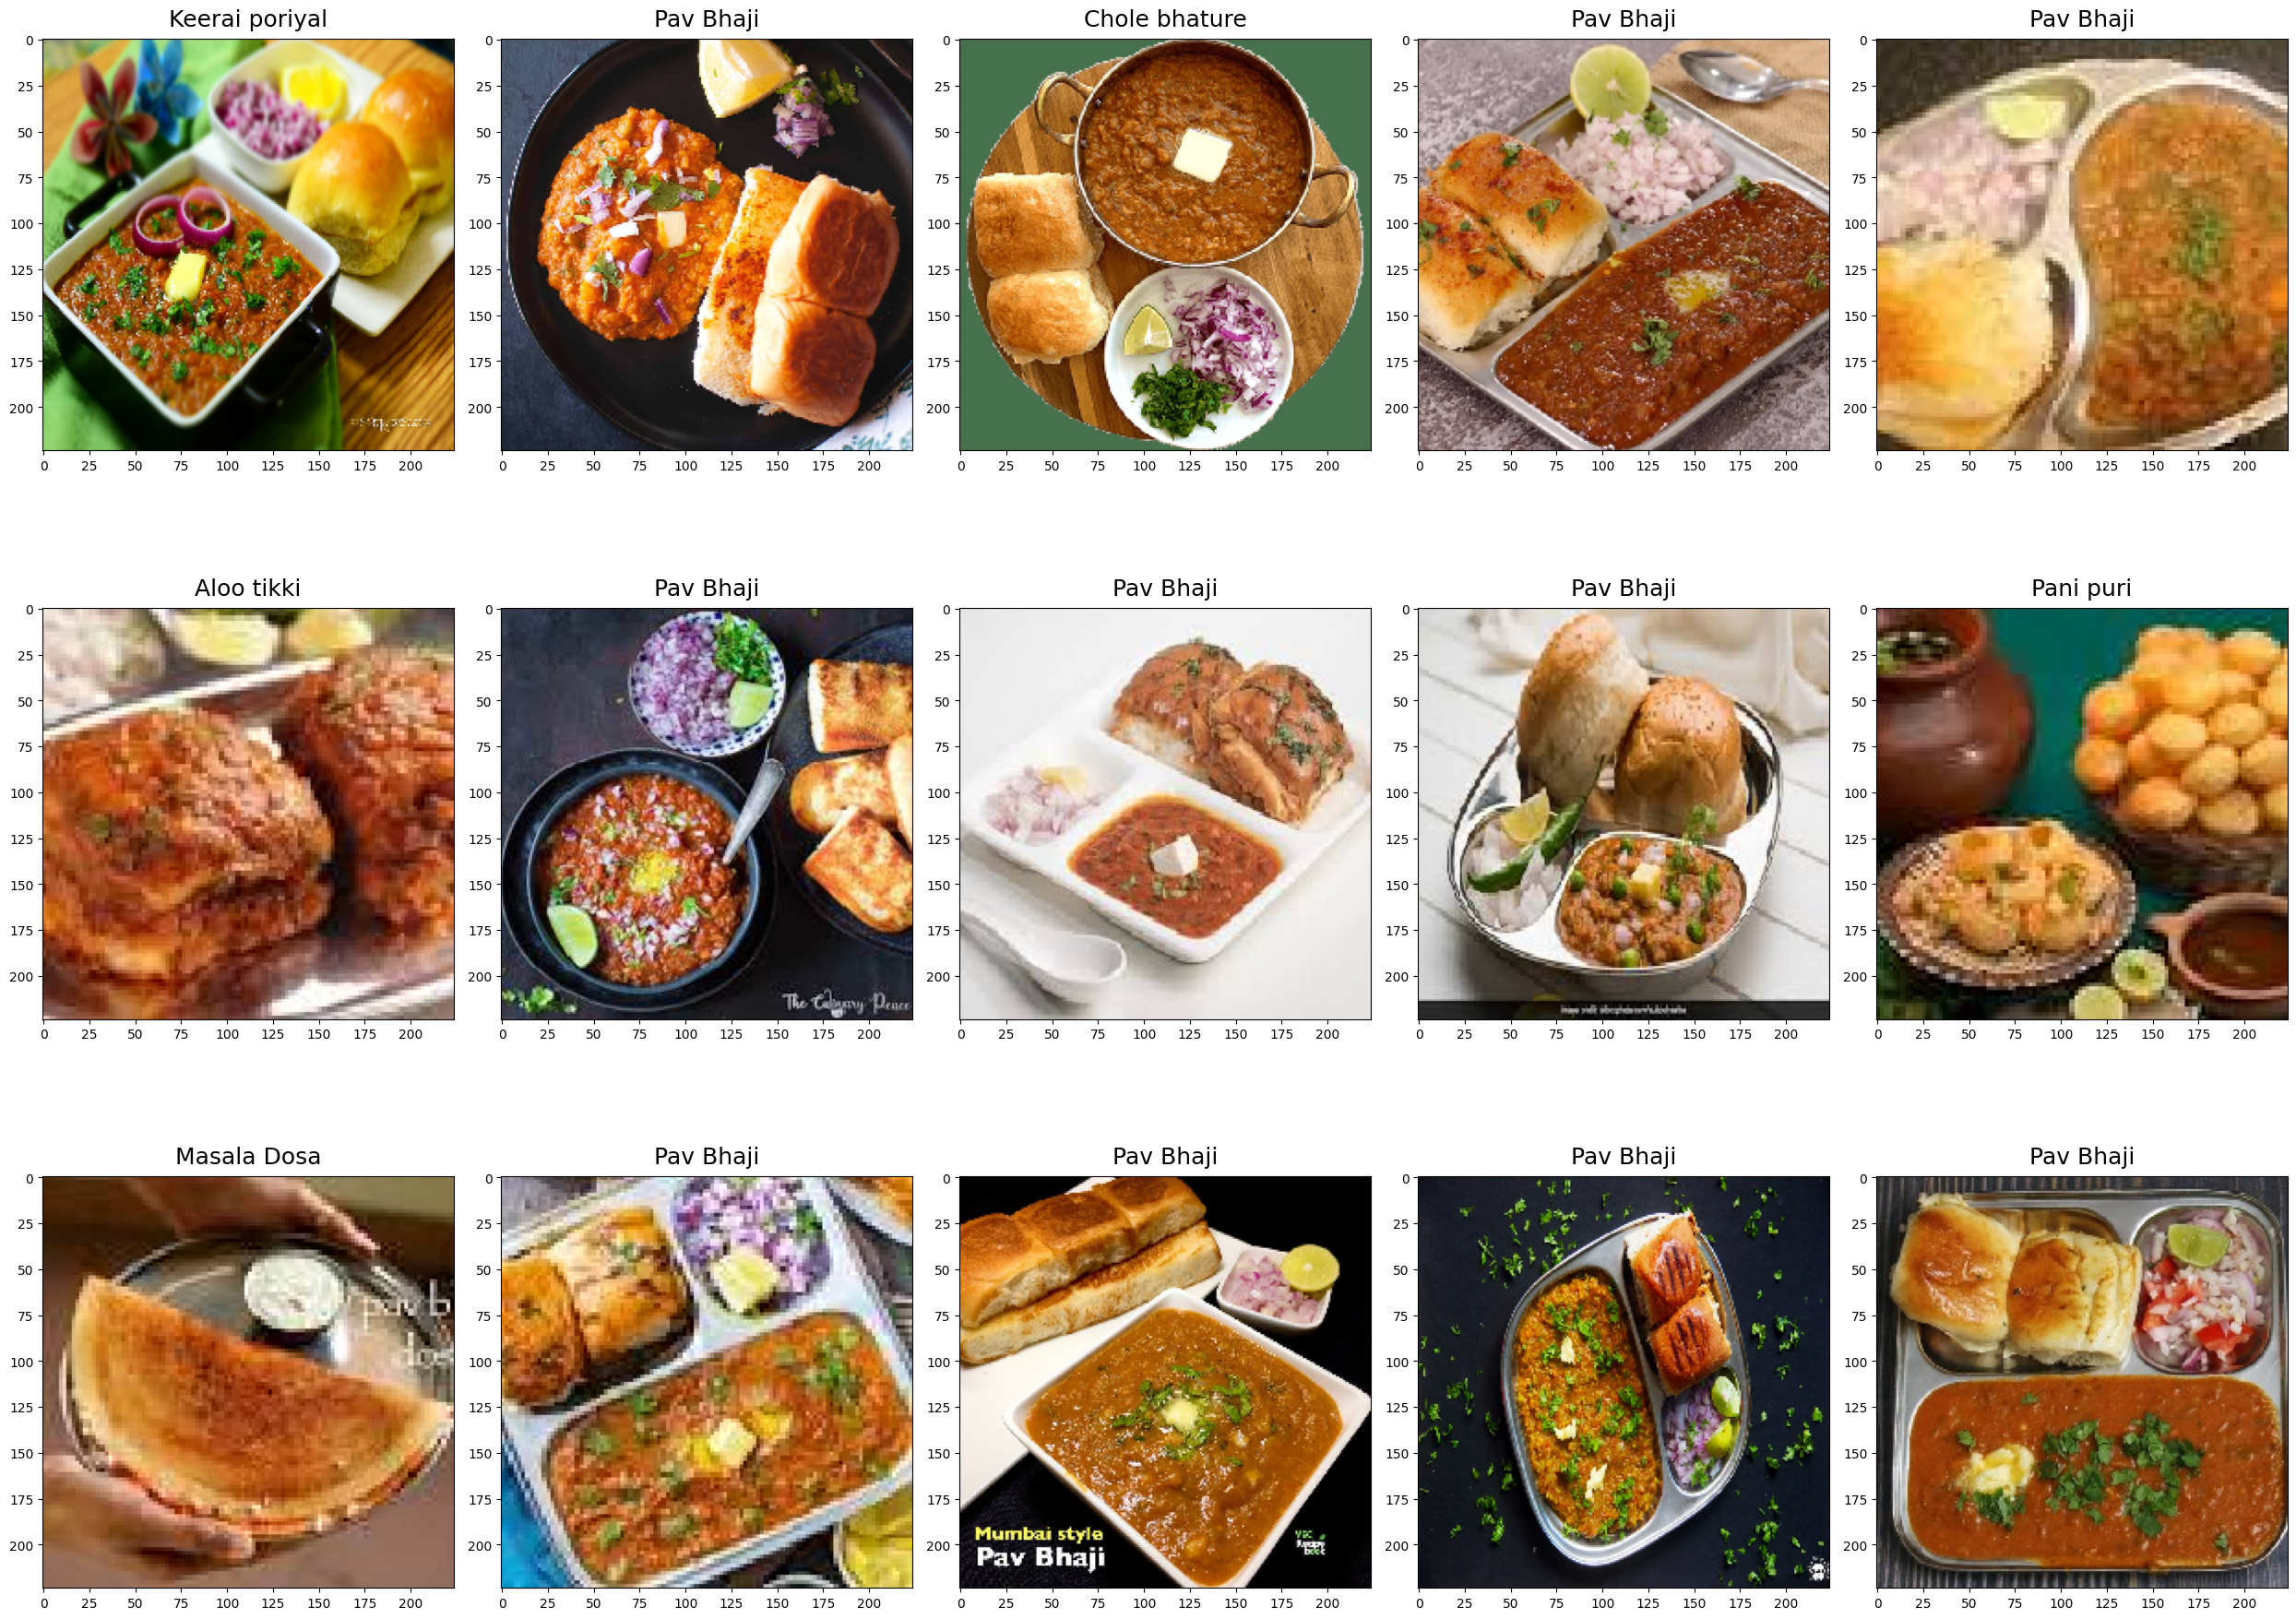

In [32]:
predict_dir("/kaggle/working/Data/test/Pav Bhaji",model)

1/1 [==============================] - 0s 47ms/step


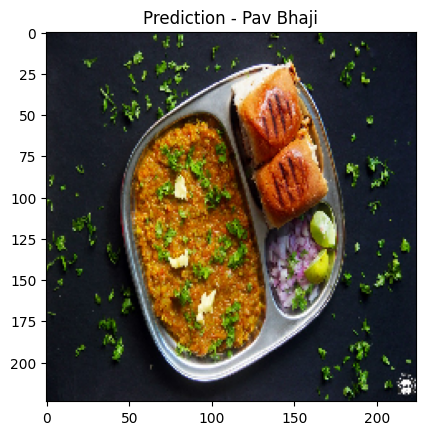

In [31]:
predict_image('/kaggle/working/Data/test/Pav Bhaji/pav-bhaji-recipe13.jpg',model)

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import pandas as pd

img_width, img_height = 224, 224

def labels_confusion_matrix():
    folder_path="/kaggle/working/Data/test"
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    cmap="viridis"
    cm_plot_labels = [i for i in range(200)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)

    # Get the number of classes
    num_classes = cm.shape[0]

    # Define a dictionary to store the classes most frequently confused with each class
    class_confusions = {}

    for i in range(num_classes):
        # Find the indices of the classes most frequently confused with class i
        confused_classes_indices = np.where(cm[i] > 0)[0]
        
        # Exclude class i itself from the list of confused classes
        confused_classes_indices = confused_classes_indices[confused_classes_indices != i]
        
        # Get the class names and counts of confusion
        confused_classes = [(class_name, cm[i, class_index]) for class_index in confused_classes_indices]
        
        # Sort the confused classes by count (most frequent first)
        confused_classes.sort(key=lambda x: x[1], reverse=True)
        
        # Store the result in the dictionary
        class_confusions[i] = confused_classes

    # Print the classes most frequently confused with each class
    for class_id, confused_classes in class_confusions.items():
        print(f"Class {class_id} is most frequently confused with:")
        for class_name, count in confused_classes:
            print(f"  Class {class_name} - Count: {count}")
        print()

#     df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
#     sns.set(font_scale=1.1) # for label size
#     plt.figure(figsize = (15,10))
#     s=sns.heatmap(df_cm, annot=True,cmap=cmap) # font size
# #     bottom,top=s.get_ylim()
# #     s.set_ylim(bottom+0.6,top-0.6)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.savefig('confusion_matrix.png')
#     plt.show()

1/1 [==============================] - 0s 25ms/step


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


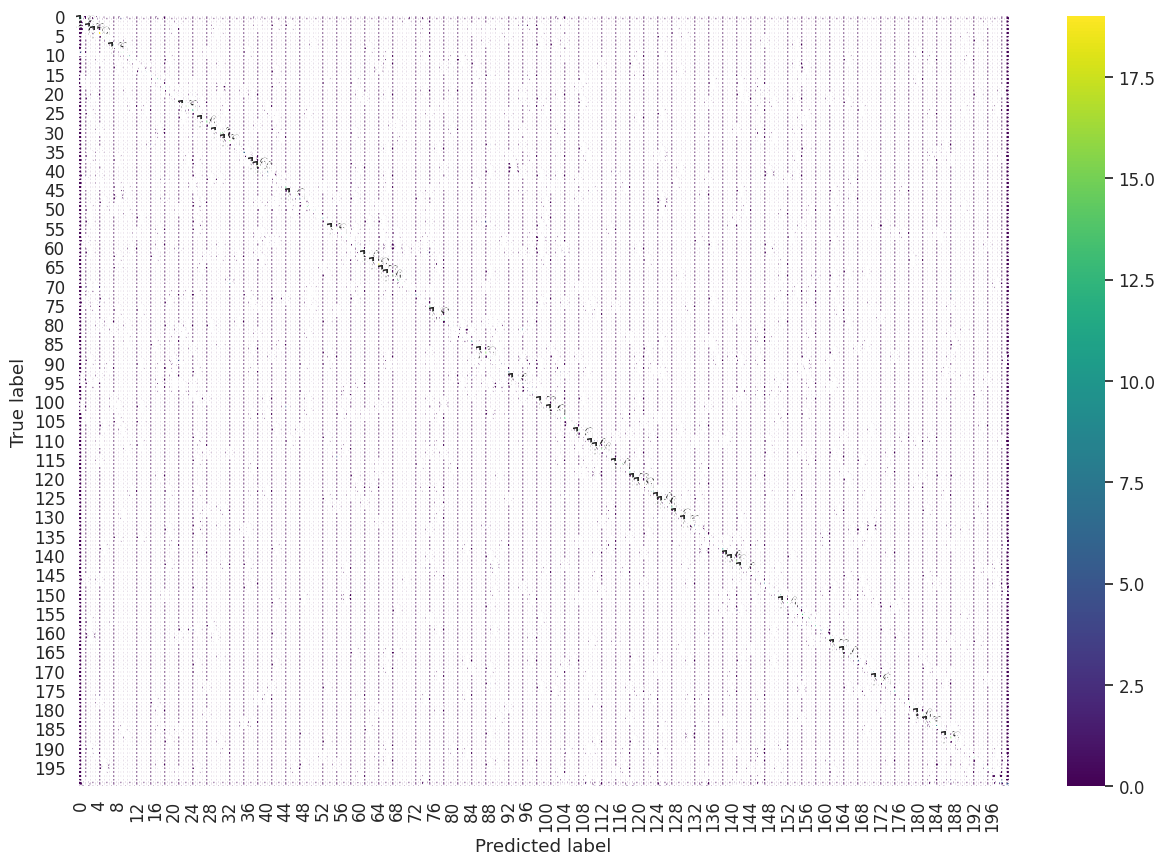

In [37]:
y_true,y_pred=labels_confusion_matrix()
print_confusion_matrix(y_true,y_pred)
